In [37]:
import numpy as np
import pandas as pd
import librosa as lib
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,multilabel_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Importar los rttm y convertirlos en un df

### Listado de carpetas y archivos en outputs

In [38]:
import os
import pandas as pd

base_dir = "outputs"

rows = []

for root, dirs, files in os.walk(base_dir):
    for fname in files:
        # Ruta relativa desde outputs
        rel_path = os.path.relpath(root, base_dir)

        # Si está directamente en outputs/
        if rel_path == ".":
            carpeta = "outputs"
            subcarpeta = ""
        else:
            partes = rel_path.split(os.sep)
            carpeta = partes[0]                 # primer nivel
            subcarpeta = os.sep.join(partes[1:]) if len(partes) > 1 else ""

        rows.append({
            "carpeta": carpeta,
            "subcarpeta": subcarpeta,
            "archivo_name": fname
        })

# Crear DataFrame
df_estructura = pd.DataFrame(rows)

# Exportar a Excel
output_excel = "estructura_outputs.xlsx"
df_estructura.to_excel(output_excel, index=False)

print(f"✔ Excel generado: {output_excel}")


✔ Excel generado: estructura_outputs.xlsx


In [39]:
import os
import pandas as pd
import math
base_dir = "outputs"
output_dir = "outputs/final_concats"

os.makedirs(output_dir, exist_ok=True)

MAX_MB = 95
MAX_BYTES = MAX_MB * 1024 * 1024

# ============================================
# RECORRER CARPETAS Y LEER CSVs
# ============================================

dfs = []

for root, dirs, files in os.walk(base_dir):
    for fname in files:

        # Solo CSV
        if not fname.lower().endswith(".csv"):
            continue

        filepath = os.path.join(root, fname)

        # Carpeta contenedora
        carpeta = os.path.basename(root)

        # Nombre base sin extensión
        name_no_ext = os.path.splitext(fname)[0]

        # Quitar sufijo "_results"
        if name_no_ext.endswith("_results"):
            name_core = name_no_ext[:-len("_results")]
        else:
            name_core = name_no_ext

        # Separar nombre - audio - nivel socio
        partes = name_core.split("-")

        nombre = partes[0] if len(partes) > 0 else ""
        numero_audio = partes[1] if len(partes) > 1 else ""
        nivel_socio = partes[2] if len(partes) > 2 else ""

        # Leer CSV
        df = pd.read_csv(filepath)

        # Agregar metadata
        df["nombre"] = nombre
        df["numero de audio"] = numero_audio
        df["nivel socio"] = nivel_socio
        df["carpeta"] = carpeta

        # Reordenar columnas
        cols_first = ["nombre", "numero de audio", "nivel socio", "carpeta"]
        other_cols = [c for c in df.columns if c not in cols_first]
        df = df[cols_first + other_cols]

        dfs.append(df)

# ============================================
# CONCATENAR TODO
# ============================================

df_resultados_concat = pd.concat(dfs, ignore_index=True)

# ============================================
# DIVIDIR EN CSVs < 100 MB (POR FILAS)
# ============================================

# Estimar tamaño promedio por fila
sample_csv = (
    df_resultados_concat
    .head(1000)
    .to_csv(index=False)
    .encode("utf-8")
)

bytes_per_row = len(sample_csv) / 1000
rows_per_file = int(MAX_BYTES / bytes_per_row)

num_parts = math.ceil(len(df_resultados_concat) / rows_per_file)

for i in range(num_parts):
    start = i * rows_per_file
    end = start + rows_per_file

    chunk_df = df_resultados_concat.iloc[start:end]

    filename = os.path.join(
        output_dir,
        f"df_resultados_concat_{i+1:02d}.csv"
    )

    chunk_df.to_csv(filename, index=False)

    size_mb = os.path.getsize(filename) / 1024 / 1024
    print(f"✔ Archivo creado: {filename} ({size_mb:.2f} MB)")

print("\nProceso completado.")


✔ Archivo creado: outputs/final_concats\df_resultados_concat_01.csv (94.78 MB)
✔ Archivo creado: outputs/final_concats\df_resultados_concat_02.csv (94.78 MB)
✔ Archivo creado: outputs/final_concats\df_resultados_concat_03.csv (93.62 MB)
✔ Archivo creado: outputs/final_concats\df_resultados_concat_04.csv (92.33 MB)
✔ Archivo creado: outputs/final_concats\df_resultados_concat_05.csv (94.30 MB)
✔ Archivo creado: outputs/final_concats\df_resultados_concat_06.csv (40.75 MB)

Proceso completado.


In [40]:
df_resultados_concat.head() 

,nombre,numero de audio,nivel socio,carpeta,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Elan_ELE,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL,Diar_SPEECH
0,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0
1,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0
2,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0
3,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0
4,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0


In [41]:
df_resultados_concat["nombre"].nunique()

25

Matriz de confusión para la etiqueta KCHI:
[[7747212  464606]
 [ 372420  511766]]

Matriz de confusión para la etiqueta OCH:
[[9024522       0]
 [  71482       0]]

Matriz de confusión para la etiqueta FEM:
[[6471808 1024544]
 [ 765818  833834]]

Matriz de confusión para la etiqueta MAL:
[[7828808  294408]
 [ 772794  199994]]

Matriz de confusión para la etiqueta ELE:
[[7914298       0]
 [1181706       0]]

Matriz de confusión para la etiqueta SIL:
[[2620924 1355374]
 [1430484 3689222]]

Informe de clasificación (multilabel uno-vs-rest):
              precision    recall  f1-score   support

        KCHI       0.52      0.58      0.55    884186
         OCH       0.00      0.00      0.00     71482
         FEM       0.45      0.52      0.48   1599652
         MAL       0.40      0.21      0.27    972788
         ELE       0.00      0.00      0.00   1181706
         SIL       0.73      0.72      0.73   5119706

   micro avg       0.63      0.53      0.58   9829520
   macro avg       0.3

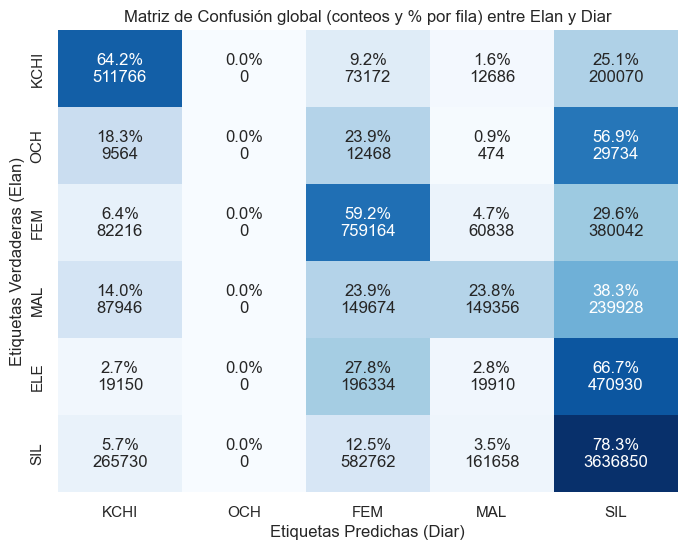

In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Si ya tenés df_resultados_concat en memoria, podés usarlo directo
# Si no, lo cargás desde el CSV que generaste antes:
# df_resultados_concat = pd.read_csv("df_resultados_concat.csv")

df = df_resultados_concat.copy()

# --- 1) Crear columnas SIL y ELE a nivel global ---

# Lista de columnas Elan que queremos verificar
cols_elan = ["Elan_KCHI", "Elan_OCH", "Elan_FEM", "Elan_MAL", "Elan_ELE"]
# (cols_diar la dejo por claridad aunque no la usamos toda)
cols_diar = ["Diar_KCHI", "Diar_OCH", "Diar_FEM", "Diar_MAL", "Diar_SPEECH"]

# SIL en Elan: 1 cuando todas las etiquetas Elan_* están en 0
df["Elan_SIL"] = (df[cols_elan].eq(0).all(axis=1)).astype(int)

# SIL en Diar: 1 - SPEECH
df["Diar_SIL"] = 1 - df["Diar_SPEECH"]

# ELE en Diar: el sistema no lo predice (todo 0)
df["Diar_ELE"] = 0

# --- 2) Definir etiquetas y armar y_true / y_pred (multilabel) ---

labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']

y_true_multi = df[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL', 'Elan_ELE', 'Elan_SIL']].values
y_pred_multi = df[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL', 'Diar_ELE', 'Diar_SIL']].values

# --- 3) Matriz de confusión multilabel + classification_report ---

conf_matrix = multilabel_confusion_matrix(y_true_multi, y_pred_multi)

for i, label in enumerate(labels):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i])
    print()

print("Informe de clasificación (multilabel uno-vs-rest):")
print(classification_report(y_true_multi, y_pred_multi, target_names=labels, zero_division=0))

# --- 4) Pasar de multilabel a singlelabel ---

def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            # Si hay múltiples etiquetas, tomamos la primera (misma política que venías usando)
            single_labels.append(indices[0])
    return np.array(single_labels)

y_true = multilabel_to_singlelabel(y_true_multi)
y_pred = multilabel_to_singlelabel(y_pred_multi)

# --- 5) Filtrar instancias sin etiqueta en y_true ---

valid_indices = y_true != -1
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

# --- 6) Matrices: conteos y normalizada ---

labels_idx = range(len(labels))

cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize=None)
cm_norm   = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize='true')

cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels)

# --- 7) Ocultar SOLO la columna 'ELE' en predichas (X), mantener fila 'ELE' en verdaderas (Y) ---
# (porque el sistema no predice ELE pero sí puede estar en Elan)
if 'ELE' in cm_counts_df.columns:
    cm_counts_df = cm_counts_df.drop(columns=['ELE'])
    cm_norm_df   = cm_norm_df.drop(columns=['ELE'])

# --- 8) Anotaciones tipo "xx.x%\nconteo" ---

annot = (cm_norm_df * 100).round(1).astype(str) + "%" + "\n" + cm_counts_df.astype(int).astype(str)

# --- 9) Graficar heatmap global y guardar ---

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm_df,        # intensidades = proporciones por fila
    annot=annot,       # texto = "porcentaje\nconteo"
    fmt='',
    cmap='Blues',
    cbar=False
)

plt.title('Matriz de Confusión global (conteos y % por fila) entre Elan y Diar')
plt.ylabel('Etiquetas Verdaderas (Elan)')
plt.xlabel('Etiquetas Predichas (Diar)')

os.makedirs('outputs/final_concats', exist_ok=True)
plt.savefig('outputs/final_concats/matriz_confusion_global_ELE_SIL_resultados_concat.png',
            dpi=300, bbox_inches='tight')
plt.show()



## Armo df_metrics para hacer gráficos con la salida del Informe de clasificación

In [43]:
labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']
label_to_idx = {label: i for i, label in enumerate(labels)}

valid_indices = (y_true != -1) & (y_pred != -1)

y_true_f = y_true[valid_indices]
y_pred_f = y_pred[valid_indices]


In [44]:
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_true_f,
    y_pred_f,
    labels=list(range(len(labels))),   # 👈 fuerza 0..5
    target_names=labels,
    output_dict=True,
    zero_division=0
)


In [45]:
df_metrics = (
    pd.DataFrame(report_dict)
      .T
      .reset_index()
      .rename(columns={
          "index": "Tipo",
          "precision": "Precisión",
          "recall": "Recall",
          "f1-score": "F1-score",
          "support": "Support"
      })
)

df_metrics = df_metrics[df_metrics["Tipo"].isin(labels)].copy()


In [46]:
def plot_metrica(df_metrics, metrica, color, filename):
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x='Tipo',
        y=metrica,
        data=df_metrics,
        palette=color
    )
    plt.title(f'{metrica} por Tipo')
    plt.ylim(0, 1)
    plt.ylabel(metrica)

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [47]:
## Tres metricas juntas

def plot_metricas_combinadas(df_metrics, filename):
    # Pasar a formato largo
    df_melted = pd.melt(
        df_metrics,
        id_vars=['Tipo'],
        value_vars=['Precisión', 'Recall', 'F1-score'],
        var_name='Métrica',
        value_name='Valor'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Tipo',
        y='Valor',
        hue='Métrica',
        data=df_melted
    )
    plt.title('Métricas por Tipo')
    plt.ylim(0, 1)
    plt.ylabel('Valor')
    plt.legend(title='Métrica')

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


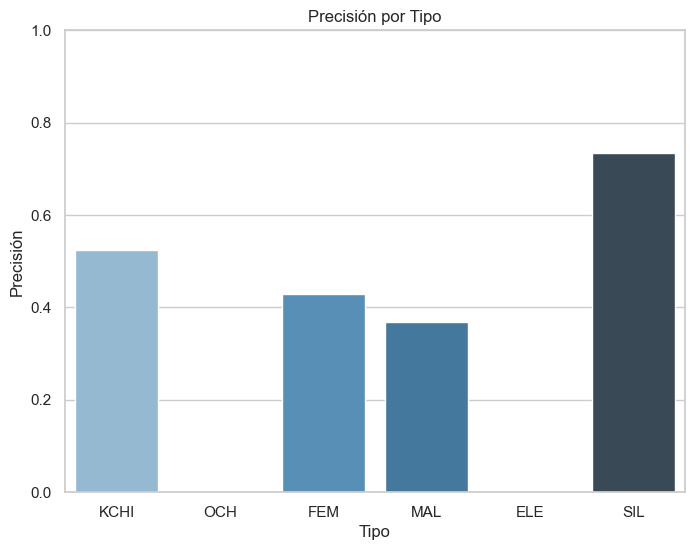

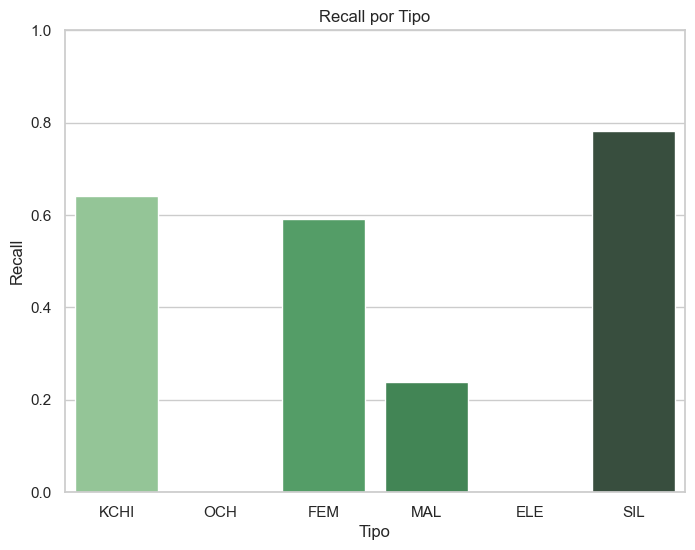

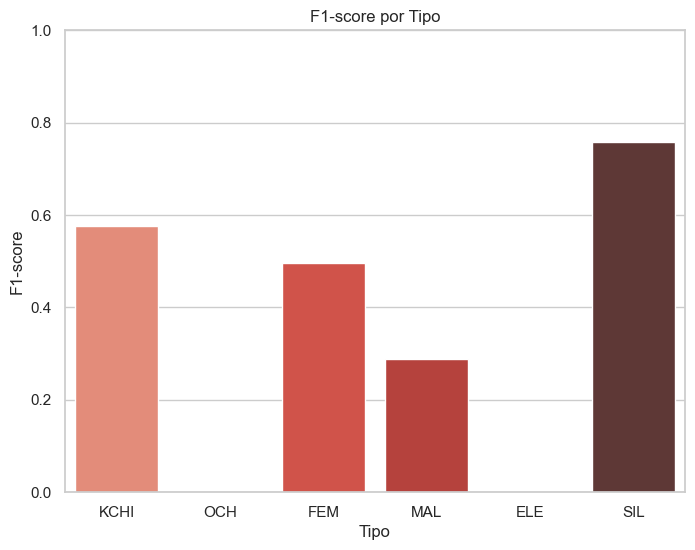

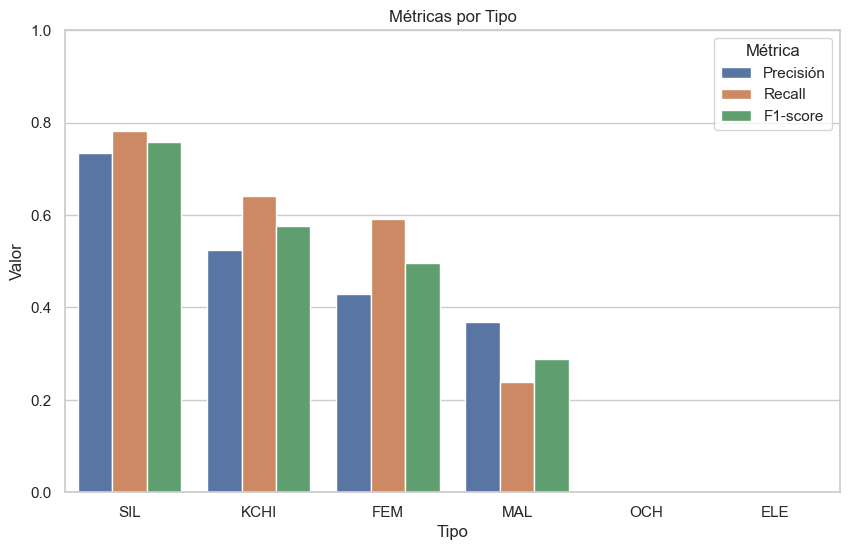

In [48]:
 plot_metrica(df_metrics, 'Precisión', 'Blues_d',
             'outputs/final_concats/precision_resultados_concat.png')

plot_metrica(df_metrics, 'Recall', 'Greens_d',
             'outputs/final_concats/recall_resultados_concat.png')

plot_metrica(df_metrics, 'F1-score', 'Reds_d',
             'outputs/final_concats/f1score_resultados_concat.png')
# Gráfico combinado
df_metrics = df_metrics.sort_values('F1-score', ascending=False)

plot_metricas_combinadas(
    df_metrics,
    'outputs/final_concats/metricas_combinadas_resultados_concat.png'
)


# Matrices por nivel SES


In [49]:
df[df["nivel socio"].isna() | (df["nivel socio"].str.strip() == "")]


,nombre,numero de audio,nivel socio,carpeta,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Elan_ELE,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL,Diar_SPEECH,Elan_SIL,Diar_SIL,Diar_ELE
0,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0,1,1,0
1,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0,1,1,0
2,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0,1,1,0
3,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0,1,1,0
4,df_resultados_concat_01,,,final_concats,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547997,df_resultados_concat_03,,,final_concats,0,0,0,0,1,0,0,0,0,0,0,1,0
4547998,df_resultados_concat_03,,,final_concats,0,0,0,0,1,0,0,0,0,0,0,1,0
4547999,df_resultados_concat_03,,,final_concats,0,0,0,0,1,0,0,0,0,0,0,1,0
4548000,df_resultados_concat_03,,,final_concats,0,0,0,0,1,0,0,0,0,0,0,1,0


In [50]:
df_eval = df_resultados_concat.copy()

df_eval["y_true"] = multilabel_to_singlelabel(y_true_multi)
df_eval["y_pred"] = multilabel_to_singlelabel(y_pred_multi)


from sklearn.metrics import classification_report

labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']
label_ids = list(range(len(labels)))

out = {}

for nivel, df_nivel in df_eval.groupby("nivel socio"):

    # filtrar inválidos EN ESTE SUBSET
    valid = (df_nivel["y_true"] != -1) & (df_nivel["y_pred"] != -1)
    df_nivel = df_nivel[valid]

    if df_nivel.empty:
        continue

    report = classification_report(
        df_nivel["y_true"],
        df_nivel["y_pred"],
        labels=label_ids,
        target_names=labels,
        output_dict=True,
        zero_division=0
    )

    df_metrics = (
        pd.DataFrame(report)
          .T
          .reset_index()
          .rename(columns={
              "index": "Tipo",
              "precision": "Precisión",
              "recall": "Recall",
              "f1-score": "F1-score",
              "support": "Support"
          })
    )

    df_metrics = df_metrics[df_metrics["Tipo"].isin(labels)]

    out[nivel] = df_metrics

    print(f"\n===== Nivel socio: {nivel} =====")
    display(df_metrics)



===== Nivel socio:  =====


,Tipo,Precisión,Recall,F1-score,Support
0,KCHI,0.524151,0.641557,0.576941,398847.0
1,OCH,0.000000,0.000000,0.000000,26120.0
2,FEM,0.428042,0.592052,0.496862,641130.0
3,MAL,0.368851,0.238244,0.289498,313452.0
4,ELE,0.000000,0.000000,0.000000,353162.0
5,SIL,0.733598,0.782623,0.757318,2323500.0



===== Nivel socio: nsb =====


,Tipo,Precisión,Recall,F1-score,Support
0,KCHI,0.423824,0.721999,0.534115,157014.0
1,OCH,0.000000,0.000000,0.000000,17602.0
2,FEM,0.357418,0.548127,0.432690,284894.0
3,MAL,0.284001,0.178549,0.219254,167209.0
4,ELE,0.000000,0.000000,0.000000,104801.0
5,SIL,0.768446,0.717516,0.742108,1176695.0



===== Nivel socio: nsm =====


,Tipo,Precisión,Recall,F1-score,Support
0,KCHI,0.645738,0.589328,0.616245,241833.0
1,OCH,0.000000,0.000000,0.000000,8518.0
2,FEM,0.496629,0.627180,0.554322,356236.0
3,MAL,0.460488,0.306497,0.368034,146243.0
4,ELE,0.000000,0.000000,0.000000,248361.0
5,SIL,0.705854,0.849428,0.771014,1146805.0


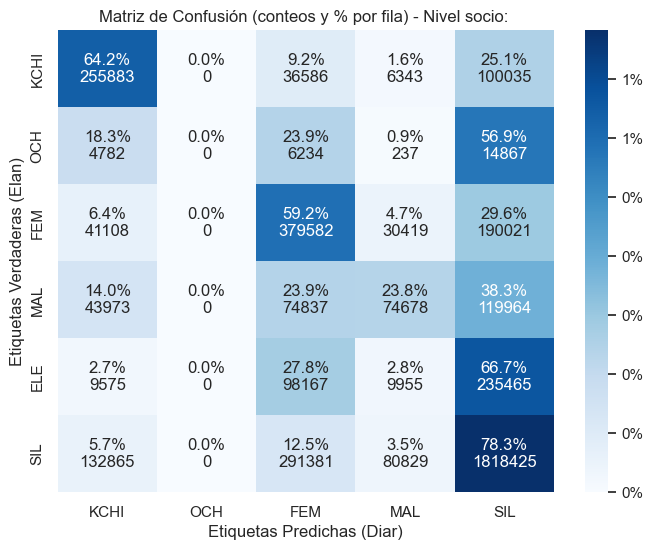

Guardada matriz para nivel socio  en: casos/df_resultados_concat\matriz_confusion__ELE_SIL.png


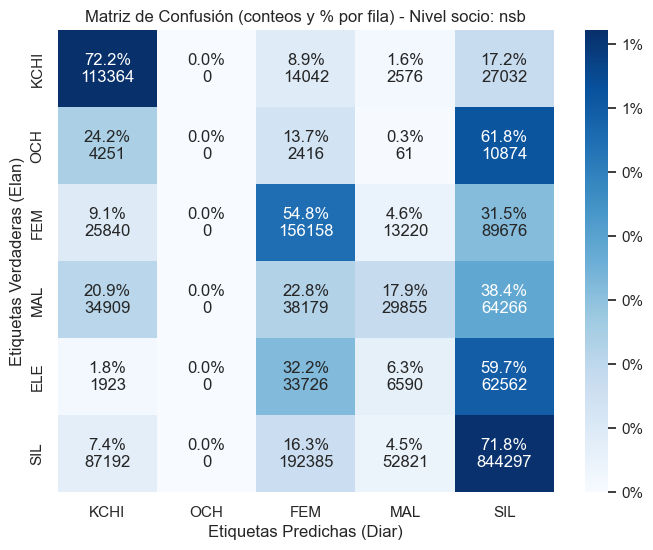

Guardada matriz para nivel socio nsb en: casos/df_resultados_concat\matriz_confusion_nsb_ELE_SIL.png


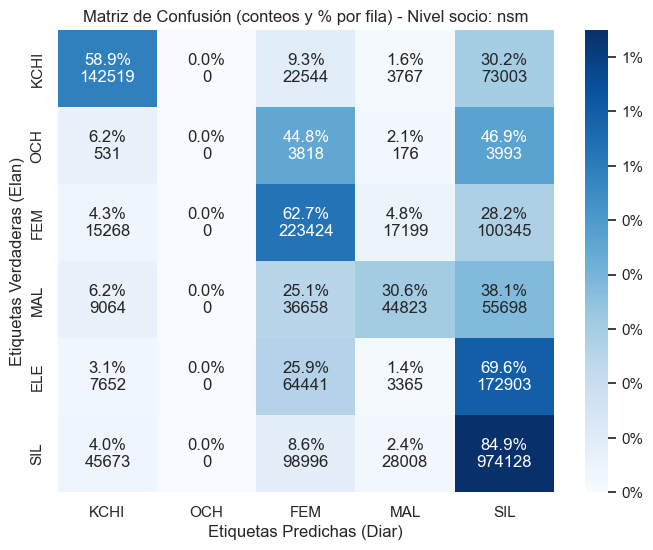

Guardada matriz para nivel socio nsm en: casos/df_resultados_concat\matriz_confusion_nsm_ELE_SIL.png


In [51]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- Función auxiliar: multilabel -> singlelabel ---
def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            single_labels.append(indices[0])  # primera etiqueta encontrada
    return np.array(single_labels)

# --- Etiquetas que vamos a usar ---
labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']
labels_idx = range(len(labels))

# --- Carpeta base de salida ---
base_out_dir = "casos/df_resultados_concat"
os.makedirs(base_out_dir, exist_ok=True)

# --- Loop por cada nivel socioeconómico ---
for nivel, df_sub in df_resultados_concat.groupby("nivel socio"):
    if df_sub.empty:
        continue
    
    df_sub = df_sub.copy()
    
    # 1) Crear SIL y ELE a partir de las columnas de Elan/Diar
    cols_elan = ["Elan_KCHI", "Elan_OCH", "Elan_FEM", "Elan_MAL", "Elan_ELE"]
    
    # SIL en Elan: todas las columnas Elan_* en 0
    df_sub["Elan_SIL"] = (df_sub[cols_elan].eq(0).all(axis=1)).astype(int)
    
    # SIL en Diar: 1 - SPEECH
    df_sub["Diar_SIL"] = 1 - df_sub["Diar_SPEECH"]
    
    # ELE en Diar: el sistema no lo predice (todo 0)
    df_sub["Diar_ELE"] = 0
    
    # 2) y_true / y_pred multilabel
    y_true_multi = df_sub[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL', 'Elan_ELE', 'Elan_SIL']].values
    y_pred_multi = df_sub[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL', 'Diar_ELE', 'Diar_SIL']].values
    
    # 3) Pasar a singlelabel
    y_true = multilabel_to_singlelabel(y_true_multi)
    y_pred = multilabel_to_singlelabel(y_pred_multi)
    
    # Filtrar sin etiqueta
    valid_indices = y_true != -1
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]
    
    if len(y_true) == 0:
        print(f"No hay instancias etiquetadas para nivel socio {nivel}, se salta.")
        continue
    
    # 4) Matrices de confusión (conteos y normalizada por fila)
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize=None)
    cm_norm   = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize='true')
    
    cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
    cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels)
    
    # Ocultar SOLO la columna ELE en predichas
    if 'ELE' in cm_counts_df.columns:
        cm_counts_df = cm_counts_df.drop(columns=['ELE'])
        cm_norm_df   = cm_norm_df.drop(columns=['ELE'])
    
    # 5) Anotaciones "xx.x%\nconteo"
    annot = (cm_norm_df * 100).round(1).astype(str) + "%" + "\n" + cm_counts_df.astype(int).astype(str)
    
    # 6) Graficar
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_norm_df,
        annot=annot,
        fmt='',
        cmap='Blues',
        cbar_kws={'format': '%.0f%%'}
    )
    
    plt.title(f'Matriz de Confusión (conteos y % por fila) - Nivel socio: {nivel}')
    plt.ylabel('Etiquetas Verdaderas (Elan)')
    plt.xlabel('Etiquetas Predichas (Diar)')
    
    # 7) Guardar por nivel socioeconómico
    nivel_str = str(nivel)
    out_path = os.path.join(base_out_dir, f"matriz_confusion_{nivel_str}_ELE_SIL.png")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Guardada matriz para nivel socio {nivel} en: {out_path}")
